# Pipeline 2: Multi-Class Disease Classification

This pipeline creates a dataset for disease classification (healthy excluded).

Goal: Balance all disease classes to ~1000 samples each for better training.

Note: This model should only run on samples classified as 'disease' by Pipeline 1.

## Step 1: Configuration Setup

In [1]:
import os
from pathlib import Path
from dotenv import load_dotenv
import pandas as pd
import numpy as np
import re
import shutil
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image

# Load environment variables
load_dotenv()

# Find project root
PROJECT_ROOT = Path(__file__).parent.parent if '__file__' in globals() else Path.cwd().parent

def make_absolute(path_str):
    """Convert relative path from .env to absolute path."""
    path = Path(path_str)
    return path.resolve() if path.is_absolute() else (PROJECT_ROOT / path).resolve()

# Dataset paths
TRAIN_LABELS_CSV = make_absolute(os.getenv('TRAIN_LABELS_CSV'))
TEST_LABELS_CSV = make_absolute(os.getenv('TEST_LABELS_CSV'))
TRAIN_IMAGES_DIR = make_absolute(os.getenv('TRAIN_IMAGES_DIR'))
TEST_IMAGES_DIR = make_absolute(os.getenv('TEST_IMAGES_DIR'))

# Output paths for DISEASE classification
OUTPUT_DISEASE_BASE_DIR = PROJECT_ROOT / 'dataset' / 'diseases'
OUTPUT_DISEASE_IMAGES_TRAIN = OUTPUT_DISEASE_BASE_DIR / 'images' / 'train'
OUTPUT_DISEASE_IMAGES_VAL = OUTPUT_DISEASE_BASE_DIR / 'images' / 'val'
OUTPUT_DISEASE_LABELS_TRAIN = OUTPUT_DISEASE_BASE_DIR / 'labels' / 'train'
OUTPUT_DISEASE_LABELS_VAL = OUTPUT_DISEASE_BASE_DIR / 'labels' / 'val'

# Plant species
PLANT_SPECIES = [s.strip() for s in os.getenv('PLANT_SPECIES').split(',')]

# Configuration
TARGET_SAMPLES_PER_CLASS = 1000

print("✓ Configuration loaded!")
print(f"\nProject root: {PROJECT_ROOT}")
print(f"Output: {OUTPUT_DISEASE_BASE_DIR}")
print(f"Target samples per class: {TARGET_SAMPLES_PER_CLASS}")

✓ Configuration loaded!

Project root: /home/tanguy/code/Tanguyrhd/personal-projects/PlantDoc-Object-Detection
Output: /home/tanguy/code/Tanguyrhd/personal-projects/PlantDoc-Object-Detection/dataset/diseases
Target samples per class: 1000


## Step 2: Load and Clean Data

In [2]:
# Load data
df_train = pd.read_csv(TRAIN_LABELS_CSV)
df_test = pd.read_csv(TEST_LABELS_CSV)

print(f"Loaded: {len(df_train)} train, {len(df_test)} test samples")

# Clean class names
for df in [df_train, df_test]:
    df['class'] = (
        df['class']
        .str.replace(r'(?i)leaf', '', regex=True)
        .str.replace(r'\s+', ' ', regex=True)
        .str.replace(r'_', ' ', regex=True)
        .str.strip()
    )

print("✓ Class names cleaned")

Loaded: 8469 train, 452 test samples
✓ Class names cleaned


## Step 3: Extract Features

In [3]:
def extract_species(text):
    for plant in PLANT_SPECIES:
        if re.search(rf"\b{plant}\b", text, flags=re.IGNORECASE):
            return plant
    return None

def extract_disease(text):
    for plant in PLANT_SPECIES:
        text = re.sub(rf"\b{plant}\b", "", text, flags=re.IGNORECASE).strip()
    # Normalize to title case to avoid duplicates like "early blight" vs "Early blight"
    return text.title() if text else "healthy"

# Extract features
df_train['species'] = df_train['class'].apply(extract_species)
df_train['disease'] = df_train['class'].apply(extract_disease)
df_test['species'] = df_test['class'].apply(extract_species)
df_test['disease'] = df_test['class'].apply(extract_disease)

print("✓ Features extracted")
print(df_train[['class', 'species', 'disease']].head())

✓ Features extracted
    class species  disease
0  Cherry  Cherry  healthy
1  Cherry  Cherry  healthy
2  Cherry  Cherry  healthy
3  Cherry  Cherry  healthy
4   Peach   Peach  healthy


## Step 4: Fix Zero Dimensions

In [4]:
def fix_zero_dimensions(df, image_folder):
    image_folder = Path(image_folder)
    for idx, row in df.iterrows():
        if row['width'] == 0 or row['height'] == 0:
            image_path = image_folder / row['filename']
            if image_path.exists():
                with Image.open(image_path) as img:
                    w, h = img.size
                    df.at[idx, 'width'] = w
                    df.at[idx, 'height'] = h
    return df

df_train = fix_zero_dimensions(df_train, TRAIN_IMAGES_DIR)
df_test = fix_zero_dimensions(df_test, TEST_IMAGES_DIR)
print("✓ Dimensions fixed")

✓ Dimensions fixed


## Step 5: Verify Files Exist

In [5]:
def verify_files_exist(df, image_folder):
    image_folder = Path(image_folder)
    existing_mask = []
    for _, row in df.iterrows():
        existing_mask.append((image_folder / row['filename']).exists())
    return df[existing_mask].copy()

df_train = verify_files_exist(df_train, TRAIN_IMAGES_DIR)
df_test = verify_files_exist(df_test, TEST_IMAGES_DIR)
print(f"✓ Verified: {len(df_train)} train, {len(df_test)} test samples")

✓ Verified: 8461 train, 452 test samples


## Step 6: Filter Out Healthy Samples

In [6]:
# Keep only disease samples (exclude healthy)
df_diseases_only = df_train[df_train['disease'] != 'healthy'].copy()

print(f"Original training samples: {len(df_train)}")
print(f"Disease samples only: {len(df_diseases_only)}")
print(f"Removed healthy samples: {len(df_train) - len(df_diseases_only)}")

Original training samples: 8461
Disease samples only: 4422
Removed healthy samples: 4039


## Step 7: Remove Very Rare Diseases and non relevent one

In [7]:
# Remove extremely rare diseases (< 0.1% of dataset)
disease_proportions = df_diseases_only['disease'].value_counts(normalize=True)
rare_threshold = 0.001
rare_diseases = disease_proportions[disease_proportions < rare_threshold].index.tolist()

print(f"Rare diseases (< {rare_threshold*100}%): {rare_diseases}")

# Additionally remove specific diseases we don't want to train on for now
excluded_diseases = ['Blight', 'Mold', 'Spot', 'Black Rot', 'Gray Spot']
all_excluded = rare_diseases + excluded_diseases

print(f"Manually excluded diseases: {excluded_diseases}")
print(f"All excluded diseases: {all_excluded}")

df_diseases_clean = df_diseases_only[~df_diseases_only['disease'].isin(all_excluded)].copy()

print(f"\nAfter removing rare and excluded diseases: {len(df_diseases_clean)} samples")
print(f"\nRemaining diseases:")
for disease in sorted(df_diseases_clean['disease'].unique()):
    count = len(df_diseases_clean[df_diseases_clean['disease'] == disease])
    print(f"  {disease}: {count} samples")

Rare diseases (< 0.1%): ['Two Spotted Spider Mites']
Manually excluded diseases: ['Blight', 'Mold', 'Spot', 'Black Rot', 'Gray Spot']
All excluded diseases: ['Two Spotted Spider Mites', 'Blight', 'Mold', 'Spot', 'Black Rot', 'Gray Spot']

After removing rare and excluded diseases: 3336 samples

Remaining diseases:
  Bacterial Spot: 266 samples
  Early Blight: 505 samples
  Late Blight: 447 samples
  Mosaic Virus: 225 samples
  Powdery Mildew: 251 samples
  Rust: 285 samples
  Scab: 158 samples
  Septoria Spot: 412 samples
  Yellow Virus: 787 samples


## Step 8: Analyze Disease Distribution

Disease distribution (before balancing):
  Yellow Virus: 787 samples
  Early Blight: 505 samples
  Late Blight: 447 samples
  Septoria Spot: 412 samples
  Rust: 285 samples
  Bacterial Spot: 266 samples
  Powdery Mildew: 251 samples
  Mosaic Virus: 225 samples
  Scab: 158 samples


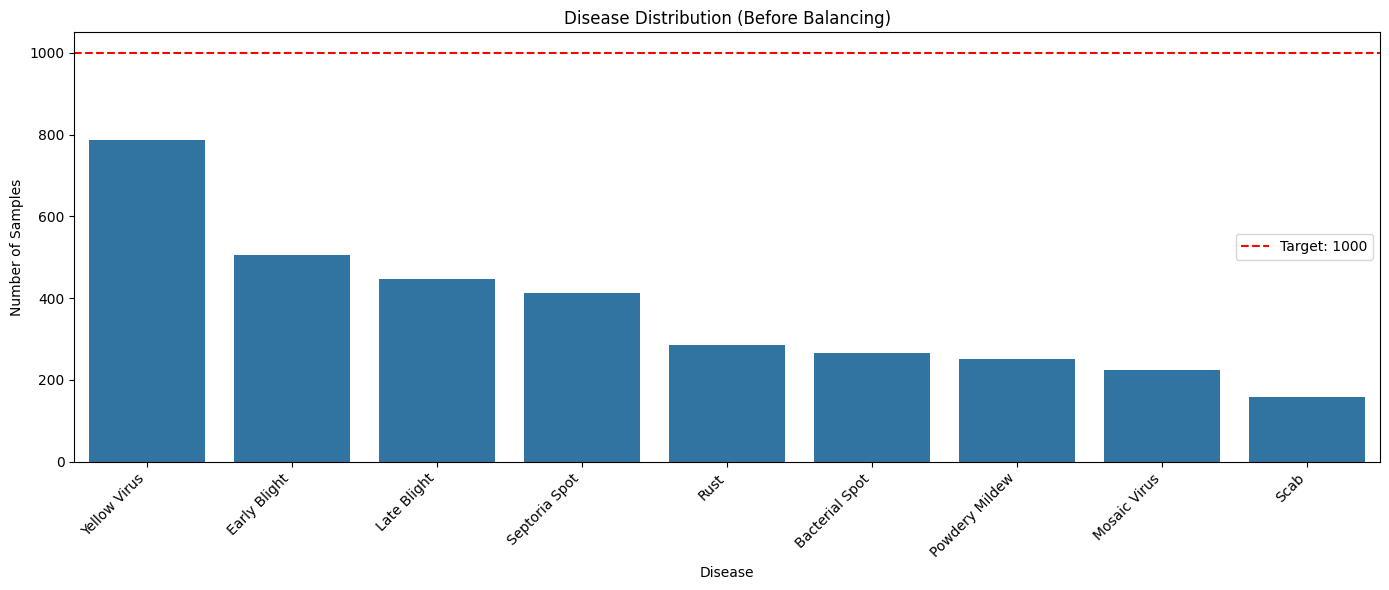

In [8]:
disease_counts = df_diseases_clean['disease'].value_counts()

print("Disease distribution (before balancing):")
for disease, count in disease_counts.items():
    print(f"  {disease}: {count} samples")

# Visualize
plt.figure(figsize=(14, 6))
sns.barplot(x=disease_counts.index, y=disease_counts.values)
plt.axhline(y=TARGET_SAMPLES_PER_CLASS, color='r', linestyle='--', label=f'Target: {TARGET_SAMPLES_PER_CLASS}')
plt.title('Disease Distribution (Before Balancing)')
plt.xlabel('Disease')
plt.ylabel('Number of Samples')
plt.xticks(rotation=45, ha='right')
plt.legend()
plt.tight_layout()
plt.show()

## Step 9: Balance Disease Classes via Duplication

In [9]:
# balanced_dfs = []

# # IMPORTANT: Only balance TRAINING data, not test data
# for disease, group in df_diseases_clean.groupby("disease"):
#     n_samples = len(group)
#     n_to_add = TARGET_SAMPLES_PER_CLASS - n_samples

#     if n_to_add > 0:
#         print(f"\n{disease}: {n_samples} → {TARGET_SAMPLES_PER_CLASS} (adding {n_to_add} duplicates)")

#         # Keep original samples
#         balanced_dfs.append(group)

#         # Add duplicates with modified filenames
#         duplicates_added = 0
#         while duplicates_added < n_to_add:
#             # Cycle through samples
#             idx = duplicates_added % n_samples
#             sample = group.iloc[idx:idx+1].copy()

#             # Modify filename to avoid conflicts
#             original_filename = sample['filename'].values[0]
#             stem = Path(original_filename).stem
#             suffix = Path(original_filename).suffix
#             new_filename = f"{stem}_dup{duplicates_added}{suffix}"
#             sample['filename'] = new_filename

#             balanced_dfs.append(sample)
#             duplicates_added += 1
#     else:
#         print(f"\n{disease}: {n_samples} (already >= target, keeping all)")
#         # Keep only up to target to avoid over-representation
#         balanced_dfs.append(group.iloc[:TARGET_SAMPLES_PER_CLASS])

# # Combine all balanced TRAINING data
# df_balanced = pd.concat(balanced_dfs, ignore_index=True)

# print(f"\n✓ TRAINING dataset balanced!")
# print(f"  Total samples: {len(df_balanced)}")

# # Process TEST data - filter out healthy and rare diseases (NO BALANCING)
# df_test_diseases = df_test[df_test['disease'] != 'healthy'].copy()
# df_test_diseases = df_test_diseases[~df_test_diseases['disease'].isin(rare_diseases)].copy()

# print(f"\n✓ TEST dataset (validation, unbalanced):")
# print(f"  Total samples: {len(df_test_diseases)}")
# print(f"\nTest disease distribution:")
# for disease in sorted(df_test_diseases['disease'].unique()):
#     count = len(df_test_diseases[df_test_diseases['disease'] == disease])
#     print(f"  {disease}: {count} samples")

In [10]:
# No balancing - use natural distribution for training
df_balanced = df_diseases_clean.copy()

print(f"\n✓ TRAINING dataset (natural distribution, no balancing)!")
print(f"  Total samples: {len(df_balanced)}")

# Show distribution
train_disease_counts = df_balanced['disease'].value_counts()
print(f"\nTraining disease distribution:")
for disease in sorted(train_disease_counts.index):
    count = train_disease_counts[disease]
    print(f"  {disease}: {count} samples")

# Process TEST data - filter out healthy and rare diseases (NO BALANCING)
df_test_diseases = df_test[df_test['disease'] != 'healthy'].copy()
df_test_diseases = df_test_diseases[~df_test_diseases['disease'].isin(all_excluded)].copy()

print(f"\n✓ TEST dataset (validation, unbalanced):")
print(f"  Total samples: {len(df_test_diseases)}")
print(f"\nTest disease distribution:")
for disease in sorted(df_test_diseases['disease'].unique()):
    count = len(df_test_diseases[df_test_diseases['disease'] == disease])
    print(f"  {disease}: {count} samples")


✓ TRAINING dataset (natural distribution, no balancing)!
  Total samples: 3336

Training disease distribution:
  Bacterial Spot: 266 samples
  Early Blight: 505 samples
  Late Blight: 447 samples
  Mosaic Virus: 225 samples
  Powdery Mildew: 251 samples
  Rust: 285 samples
  Scab: 158 samples
  Septoria Spot: 412 samples
  Yellow Virus: 787 samples

✓ TEST dataset (validation, unbalanced):
  Total samples: 216

Test disease distribution:
  Bacterial Spot: 14 samples
  Early Blight: 36 samples
  Late Blight: 24 samples
  Mosaic Virus: 36 samples
  Powdery Mildew: 6 samples
  Rust: 21 samples
  Scab: 13 samples
  Septoria Spot: 24 samples
  Yellow Virus: 42 samples


## Step 10: Visualize Balanced Distribution

In [11]:
# balanced_counts = df_balanced['disease'].value_counts()

# print("\nFinal disease distribution (after balancing):")
# for disease in sorted(balanced_counts.index):
#     count = balanced_counts[disease]
#     print(f"  {disease}: {count} samples")

# # Visualize
# plt.figure(figsize=(14, 6))
# sns.barplot(x=sorted(balanced_counts.index), y=[balanced_counts[d] for d in sorted(balanced_counts.index)])
# plt.axhline(y=TARGET_SAMPLES_PER_CLASS, color='g', linestyle='--', label=f'Target: {TARGET_SAMPLES_PER_CLASS}')
# plt.title('Disease Distribution (After Balancing)')
# plt.xlabel('Disease')
# plt.ylabel('Number of Samples')
# plt.xticks(rotation=45, ha='right')
# plt.legend()
# plt.tight_layout()
# plt.show()


Final disease distribution (natural, no balancing):
  Bacterial Spot: 266 samples
  Early Blight: 505 samples
  Late Blight: 447 samples
  Mosaic Virus: 225 samples
  Powdery Mildew: 251 samples
  Rust: 285 samples
  Scab: 158 samples
  Septoria Spot: 412 samples
  Yellow Virus: 787 samples


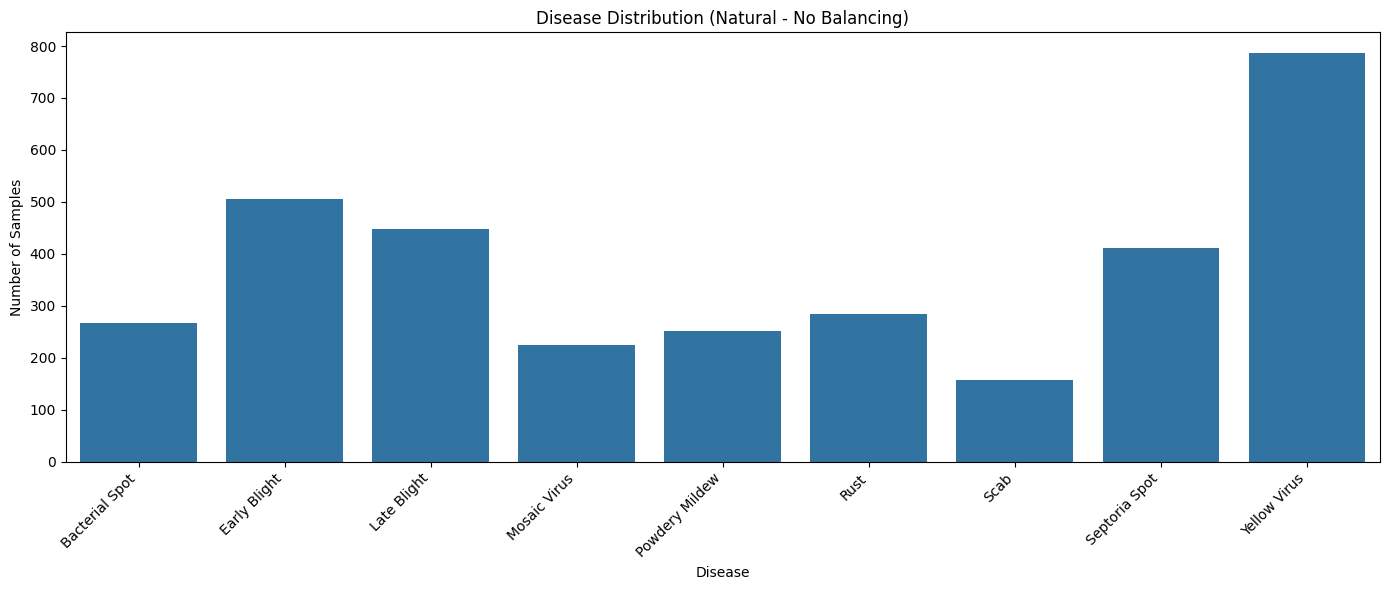

In [12]:
final_counts = df_balanced['disease'].value_counts()

print("\nFinal disease distribution (natural, no balancing):")
for disease in sorted(final_counts.index):
    count = final_counts[disease]
    print(f"  {disease}: {count} samples")

# Visualize
plt.figure(figsize=(14, 6))
sns.barplot(x=sorted(final_counts.index), y=[final_counts[d] for d in sorted(final_counts.index)])
plt.title('Disease Distribution (Natural - No Balancing)')
plt.xlabel('Disease')
plt.ylabel('Number of Samples')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

## Step 11: Create Disease-to-Index Mapping

In [13]:
# Create disease to index mapping (sorted alphabetically for consistency)
diseases = sorted(df_diseases_clean['disease'].unique())
disease2idx = {disease: i for i, disease in enumerate(diseases)}

print(f"Disease to Index Mapping ({len(disease2idx)} classes):")
for disease, idx in disease2idx.items():
    count = len(df_diseases_clean[df_diseases_clean['disease'] == disease])
    print(f"  {idx}: {disease} ({count} samples)")

Disease to Index Mapping (9 classes):
  0: Bacterial Spot (266 samples)
  1: Early Blight (505 samples)
  2: Late Blight (447 samples)
  3: Mosaic Virus (225 samples)
  4: Powdery Mildew (251 samples)
  5: Rust (285 samples)
  6: Scab (158 samples)
  7: Septoria Spot (412 samples)
  8: Yellow Virus (787 samples)


## Step 12: Create Output Directories

In [14]:
OUTPUT_DISEASE_IMAGES_TRAIN.mkdir(parents=True, exist_ok=True)
OUTPUT_DISEASE_IMAGES_VAL.mkdir(parents=True, exist_ok=True)
OUTPUT_DISEASE_LABELS_TRAIN.mkdir(parents=True, exist_ok=True)
OUTPUT_DISEASE_LABELS_VAL.mkdir(parents=True, exist_ok=True)

print("✓ Output directories created")
print(f"  {OUTPUT_DISEASE_BASE_DIR}")

✓ Output directories created
  /home/tanguy/code/Tanguyrhd/personal-projects/PlantDoc-Object-Detection/dataset/diseases


## Step 13: Convert to YOLO Format and Export

In [15]:
def convert_bbox_to_yolo(row):
    x_center = (row['xmin'] + row['xmax']) / 2 / row['width']
    y_center = (row['ymin'] + row['ymax']) / 2 / row['height']
    bbox_width = (row['xmax'] - row['xmin']) / row['width']
    bbox_height = (row['ymax'] - row['ymin']) / row['height']
    return x_center, y_center, bbox_width, bbox_height

def export_to_yolo(df, images_dir, output_images_dir, output_labels_dir, class_mapping):
    exported = 0
    skipped = 0

    for filename, group in df.groupby("filename"):
        try:
            # Check if this is a duplicate (has _dup in name)
            if '_dup' in filename:
                # Get original filename
                original_filename = filename.split('_dup')[0] + Path(filename).suffix
                src = Path(images_dir) / original_filename
            else:
                src = Path(images_dir) / filename

            if not src.exists():
                skipped += 1
                continue

            dst = Path(output_images_dir) / filename
            shutil.copy2(src, dst)

            # Create label file
            label_file = Path(output_labels_dir) / (Path(filename).stem + ".txt")
            with open(label_file, "w") as f:
                for _, row in group.iterrows():
                    cls_idx = class_mapping[row['disease']]
                    x_c, y_c, w, h = convert_bbox_to_yolo(row)
                    f.write(f"{cls_idx} {x_c:.6f} {y_c:.6f} {w:.6f} {h:.6f}\n")
            exported += 1
        except Exception as e:
            print(f"Error: {filename} - {e}")
            skipped += 1

    return exported, skipped

print("Exporting TRAINING data to YOLO format (natural distribution, no balancing)...")
exported_train, skipped_train = export_to_yolo(
    df_diseases_clean,  # Use natural distribution
    TRAIN_IMAGES_DIR,
    OUTPUT_DISEASE_IMAGES_TRAIN,
    OUTPUT_DISEASE_LABELS_TRAIN,
    disease2idx
)

print(f"\n✓ Training export complete!")
print(f"  Total samples: {len(df_diseases_clean)}")
print(f"  Exported: {exported_train} images")
print(f"  Skipped: {skipped_train} images")

Exporting TRAINING data to YOLO format (natural distribution, no balancing)...

✓ Training export complete!
  Total samples: 3336
  Exported: 1139 images
  Skipped: 0 images


In [16]:
print("\nExporting TEST data to VALIDATION set...")
exported_val, skipped_val = export_to_yolo(
    df_test_diseases,
    TEST_IMAGES_DIR,
    OUTPUT_DISEASE_IMAGES_VAL,
    OUTPUT_DISEASE_LABELS_VAL,
    disease2idx
)

print(f"\n✓ Validation export complete!")
print(f"  Exported: {exported_val} images")
print(f"  Skipped: {skipped_val} images")

print(f"\n📊 Summary:")
print(f"  Training: {exported_train} images (balanced)")
print(f"  Validation: {exported_val} images (natural distribution)")


Exporting TEST data to VALIDATION set...

✓ Validation export complete!
  Exported: 107 images
  Skipped: 0 images

📊 Summary:
  Training: 1139 images (balanced)
  Validation: 107 images (natural distribution)


## Step 14: Generate YAML Configuration

In [17]:
import yaml

yaml_content = {
    'path': str(OUTPUT_DISEASE_BASE_DIR.resolve()),
    'train': 'images/train',
    'val': 'images/val',
    'nc': len(disease2idx),
    'names': {idx: disease for disease, idx in disease2idx.items()}
}

yaml_path = OUTPUT_DISEASE_BASE_DIR / 'dataset.yaml'
with open(yaml_path, 'w') as f:
    yaml.dump(yaml_content, f, default_flow_style=False, sort_keys=False)

print("✓ YAML configuration created")
print(f"\nLocation: {yaml_path}")
print(f"\nClasses ({len(disease2idx)}):")
for idx in sorted(yaml_content['names'].keys()):
    print(f"  {idx}: {yaml_content['names'][idx]}")

✓ YAML configuration created

Location: /home/tanguy/code/Tanguyrhd/personal-projects/PlantDoc-Object-Detection/dataset/diseases/dataset.yaml

Classes (9):
  0: Bacterial Spot
  1: Early Blight
  2: Late Blight
  3: Mosaic Virus
  4: Powdery Mildew
  5: Rust
  6: Scab
  7: Septoria Spot
  8: Yellow Virus


## Step 15: Summary

In [18]:
print("=" * 60)
print("DISEASE CLASSIFICATION DATASET READY")
print("=" * 60)
print(f"\n📊 Dataset Statistics:")
print(f"  Total samples: {len(df_diseases_clean)}")
print(f"  Number of disease classes: {len(disease2idx)}")
print(f"  Target per class: {TARGET_SAMPLES_PER_CLASS}")
print(f"\n  Class distribution:")
for disease in sorted(disease2idx.keys()):
    count = len(df_diseases_clean[df_diseases_clean['disease'] == disease])
    print(f"    [{disease2idx[disease]}] {disease}: {count} samples")
print(f"\n📁 Location: {OUTPUT_DISEASE_BASE_DIR}")
print(f"📝 Config: {yaml_path}")
print(f"\n⚠️  Important: This model should only process samples")
print(f"   classified as 'disease' by the binary model (Pipeline 1)")
print(f"\n✅ Ready for YOLO training!")
print("=" * 60)

DISEASE CLASSIFICATION DATASET READY

📊 Dataset Statistics:
  Total samples: 3336
  Number of disease classes: 9
  Target per class: 1000

  Class distribution:
    [0] Bacterial Spot: 266 samples
    [1] Early Blight: 505 samples
    [2] Late Blight: 447 samples
    [3] Mosaic Virus: 225 samples
    [4] Powdery Mildew: 251 samples
    [5] Rust: 285 samples
    [6] Scab: 158 samples
    [7] Septoria Spot: 412 samples
    [8] Yellow Virus: 787 samples

📁 Location: /home/tanguy/code/Tanguyrhd/personal-projects/PlantDoc-Object-Detection/dataset/diseases
📝 Config: /home/tanguy/code/Tanguyrhd/personal-projects/PlantDoc-Object-Detection/dataset/diseases/dataset.yaml

⚠️  Important: This model should only process samples
   classified as 'disease' by the binary model (Pipeline 1)

✅ Ready for YOLO training!
